In [1]:
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.transforms import v2

In [2]:
image_ttls = os.listdir('data_yael')

In [3]:
list_of_images = [np.asarray(Image.open(f'data_yael/{img_title}')) for img_title in image_ttls]

## Create customed dataloader to laod the provided dataset to the resnet model that we trained before

In [4]:
class HomeAssignmentDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.list_of_images = list_of_images
        self.transform = transform
        
    def __len__(self):
        return len(self.list_of_images)

    def __getitem__(self, idx):
        image_np = list_of_images[idx]
        if image_np.ndim==3:
            image_np = image_np.mean(2)
        image_np = image_np/255
        image_torch = torch.from_numpy(np.expand_dims(image_np, 0))
        if self.transform is not None:
            image_torch = self.transform(image_torch)
            
        return image_torch.float()
        
ha_dataset = HomeAssignmentDataset(list_of_images, transform = v2.Resize((28, 28)))
ha_loader = torch.utils.data.DataLoader(ha_dataset, batch_size=100)

torch.Size([100, 1, 28, 28])


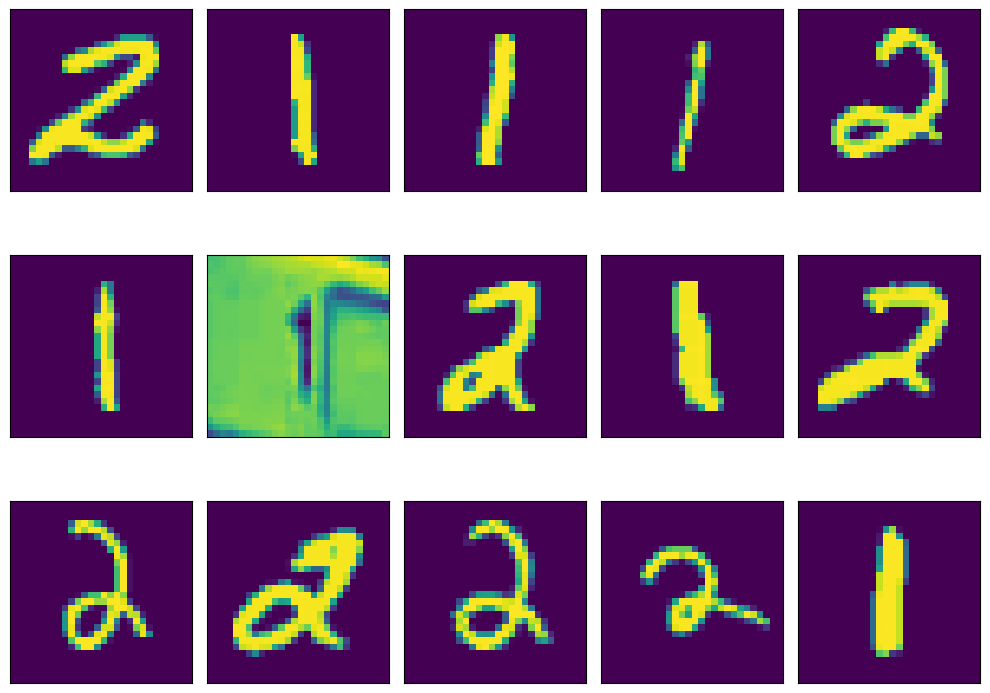

In [5]:
for images in ha_loader:
    print(images.shape)
    break
    
plt.figure(figsize=(10,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()

## get the last linear layer neurons for each image as embedding for each imageector of 512

In [6]:
# model = torch.jit.load('resnet18MNIST.pt')
model = models.resnet18(pretrained=False)

def change_layers(model):
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(512, 10, bias=True)
change_layers(model)

model = torch.load('resnet18MNIST')
model.eval()
model.to('cpu')
print('model loaded')

model loaded


In [7]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.avgpool.register_forward_hook(get_activation('avgpool'))
for x in ha_loader:
    output = model(x)

In [8]:
activation['avgpool'].shape

torch.Size([100, 512, 1, 1])

In [9]:
nn_embed = activation['avgpool'][:,:,0,0].numpy()

## plot the embedding vecors

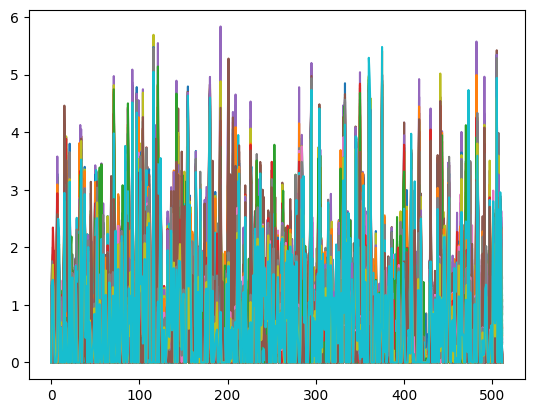

In [10]:
plt.plot(nn_embed.T)
plt.show()

## I tried pca and tSNE eith different perplexity for dimentionality reduction and chose the one that outputs good visual separation

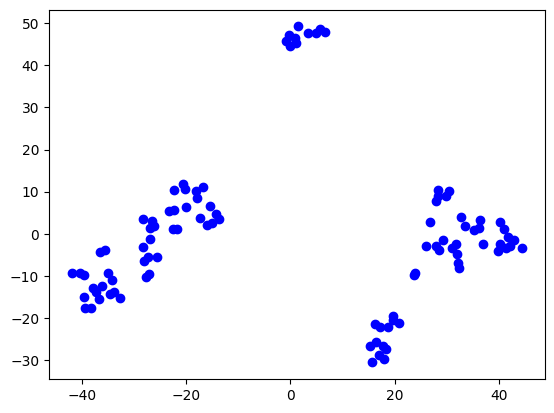

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(2, perplexity=5, random_state=42)
tsne_x = tsne.fit_transform(nn_embed)

plt.scatter(tsne_x[:,0], tsne_x[:,1], color='blue')
plt.show()

## The samples form 3-4 clusters. I tried both and eather way I am obtaining one of the clusters contains all anomalous images. I'll present result for 3 clusters.

In [12]:
from  sklearn.cluster import KMeans
clustering = KMeans(3, random_state=21)

In [13]:
pred = clustering.fit_predict(tsne_x)

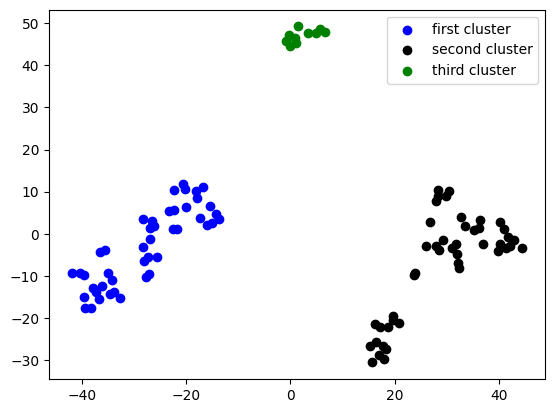

In [14]:
plt.scatter(tsne_x[pred==0][:,0], tsne_x[pred==0][:,1], color='b', label='first cluster')
plt.scatter(tsne_x[pred==1][:,0], tsne_x[pred==1][:,1], color='k', label='second cluster')
plt.scatter(tsne_x[pred==2][:,0], tsne_x[pred==2][:,1], color='g', label='third cluster')
plt.legend()
plt.savefig('clustering')
plt.show()

In [15]:
def plot_clulster_imgs(cluster_images, sup_title):
    plt.figure(figsize=(10,8))
    for i in range(min(15, len(cluster_images))):
        plt.subplot(3,5,i+1)
        plt.imshow(cluster_images[i])
        plt.xticks([], [])
        plt.yticks([], [])
    plt.suptitle(sup_title)
    plt.tight_layout()

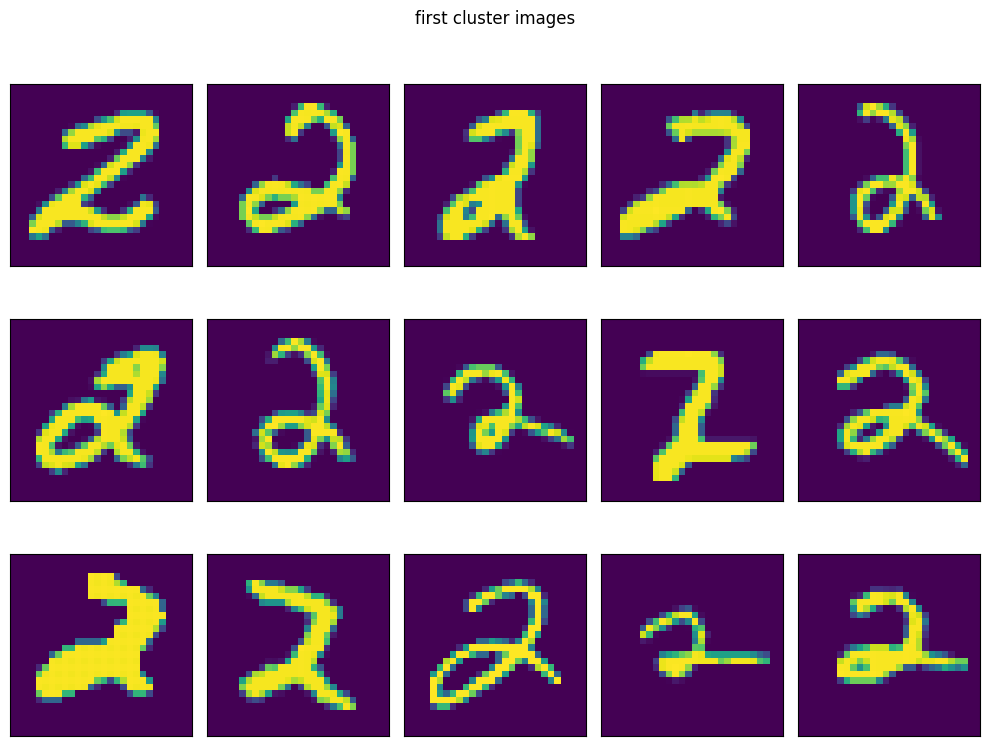

In [16]:
cluster_images = [list_of_images[i] for i in range(len(list_of_images))if pred[i]==0]
plot_clulster_imgs(cluster_images, 'first cluster images')

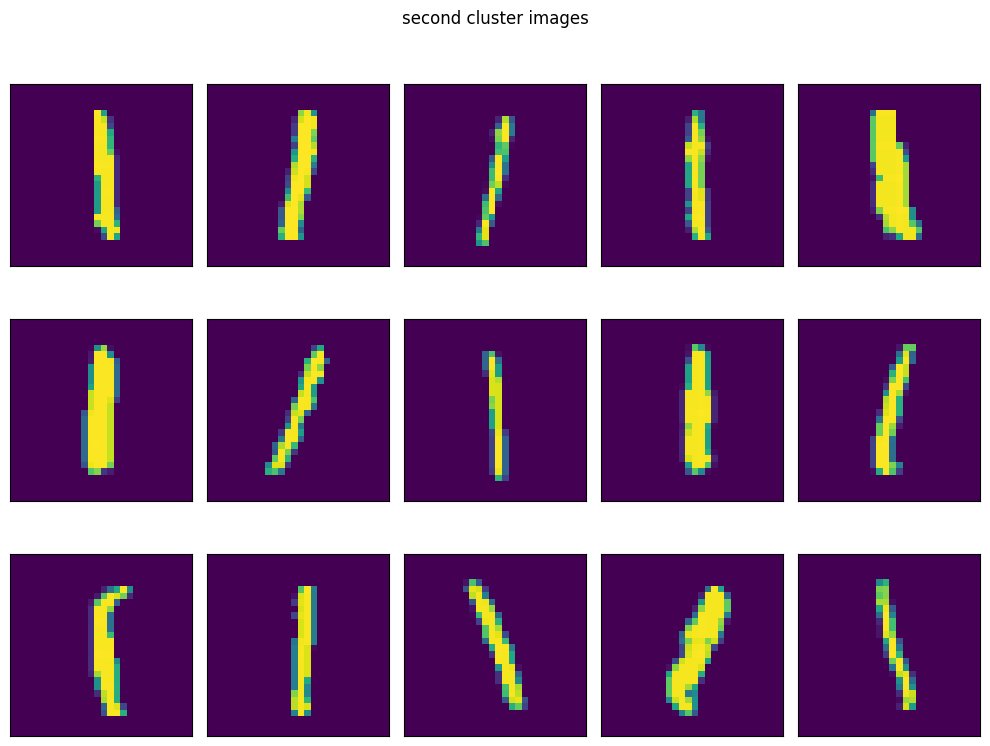

In [17]:
cluster_images = [list_of_images[i] for i in range(len(list_of_images))if pred[i]==1]
plot_clulster_imgs(cluster_images, 'second cluster images')

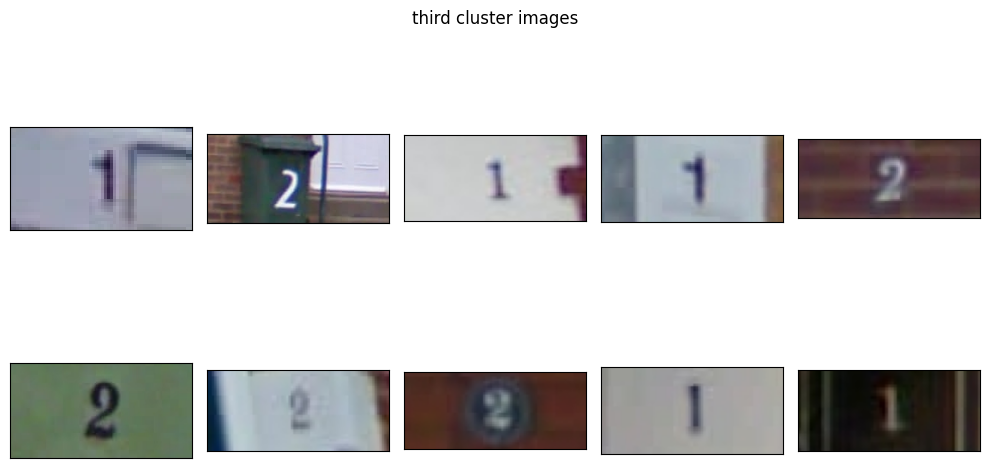

In [18]:
cluster_images = [list_of_images[i] for i in range(len(list_of_images))if pred[i]==2]
plot_clulster_imgs(cluster_images, 'third cluster images')

## all the anomaly images are predicted as third cluster

## all the MNIST images are predicted as first and second cluster